# Cheminformatic notebook for picking subsets of compound libraries

## Before you use:

* Obtain an SDF file containing a compound library
* Install RDkit conda enviroment

        conda create -n rdkit rdkit pandas ipykernel xlsxwriter

    or 

        conda env create -f rdkit_env.yml

* Activate RDkit conda enviroment

        conda actiavte rdkit

## Capabilities:

* Remove substructures (e.g. functional handles) to identify fragments
* Filter by:
    * catalog
    * QED score
    * molecular properties
    * geometry
    * substructure
    
* Pick diverse subsets using pickers:
    * Random()
    * MaxMinPicker()
    * ClusterMethod()
    * HierarchicalClusterPicker()
    * LeaderPicker()
    
* Save libaries as:
    * .xlsx
    * .sdf


## Import packages

In [1]:
import pandas as pd
import numpy as np
from glob import glob
from rdkit import Chem
from rdkit.Chem import AllChem, QED, PandasTools, rdMolDescriptors, Crippen, Draw, rdFMCS, rdRGroupDecomposition, rdFingerprintGenerator
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker, ClusterMethod, HierarchicalClusterPicker, LeaderPicker
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from pathlib import Path
import matplotlib.pyplot as plt


PandasTools.RenderImagesInAllDataFrames(images=True)
PandasTools.InstallPandasTools()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.mode.copy_on_write = True
print(Path().absolute())


<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterMatcherBase> already registered; second conversion method ignored.


/mnt/d/OneDrive - University of North Carolina at Chapel Hill/Weeks_Lab/Jordan/Library_screen


## Cheminformatic functions

In [2]:
def remove_substructure(df, molcol='ROMol', substructures=['[#8]=[#6]-[#6]-[#6]-[#6]1(-[#6]-[#6]-[#6]#[#6])-[#7]=[#7]-1', '[#7]-[#6]-[#6]-[#6]1(-[#6]-[#6]-[#6]#[#6])-[#7]=[#7]-1']):
     df['Fragment'] = df[molcol]
     for substructure in substructures:
          substructure = Chem.MolFromSmarts(substructure)
          df['Fragment'] = df['Fragment'].apply(lambda x: AllChem.DeleteSubstructs(x, substructure))
     df['Fragment'].apply(lambda x: AllChem.EmbedMolecule(Chem.AddHs(x)))
     df['Fragment'].apply(lambda x: Chem.SanitizeMol(x))
     
     return df


def get_qed(df, molcol='ROMol'):
    df['QED'] = df[molcol].apply(lambda x: QED.default(x))
    df['MW'] = df[molcol].apply(lambda x: QED.properties(x)[0])
    df['ALOGP'] = df[molcol].apply(lambda x: QED.properties(x)[1])
    df['HBA'] = df[molcol].apply(lambda x: QED.properties(x)[2])
    df['HBD'] = df[molcol].apply(lambda x: QED.properties(x)[3])
    df['PSA'] = df[molcol].apply(lambda x: QED.properties(x)[4])
    df['ROTB'] = df[molcol].apply(lambda x: QED.properties(x)[5])
    df['AROM'] = df[molcol].apply(lambda x: QED.properties(x)[6])
    df['ALERTS'] = df[molcol].apply(lambda x: QED.properties(x)[7])

    return df


def get_moldecriptors(df, molcol='ROMol'):   
    df['Num Ring'] = df[molcol].apply(lambda x: rdMolDescriptors.CalcNumRings(x))
    df['Num ArHetcy'] = df[molcol].apply(lambda x: rdMolDescriptors.CalcNumAromaticHeterocycles(x))
    df['Num Hetcy'] = df[molcol].apply(lambda x: rdMolDescriptors.CalcNumHeterocycles(x))
    df['Num Hetatm'] = df[molcol].apply(lambda x: rdMolDescriptors.CalcNumHeteroatoms(x))
    df['Num Ring'] = df[molcol].apply(lambda x: rdMolDescriptors.CalcNumRings(x))
    df['Num Spiro'] = df[molcol].apply(lambda x: rdMolDescriptors.CalcNumSpiroAtoms(x))
    df['Frac Sp3'] = df[molcol].apply(lambda x: rdMolDescriptors.CalcFractionCSP3(x))
    df['MR'] = df[molcol].apply(lambda x: Crippen.MolMR(x))
    df['NPR1'] = df[molcol].apply(lambda x: rdMolDescriptors.CalcNPR1(x))
    df['NPR2'] = df[molcol].apply(lambda x: rdMolDescriptors.CalcNPR2(x))
    
    # Get ligand geometry
    df['Geometry'] = 'Balanced'
    df.loc[df.eval('NPR1 - NPR2 + 0.5 < 0'), 'Geometry'] = 'Rod-like'
    df.loc[df.eval('- NPR1 - NPR2 + 1.5 < 0'), 'Geometry'] = 'Sphere-like'
    df.loc[df.eval('NPR2 - 0.75 < 0'), 'Geometry'] = 'Disc-like'
    df['Geometry'] = df['Geometry'].astype('category')

    return df


def filter_by_catalog(df, molcol='ROMol', catalog='ALL'):
    df.reset_index()
    params_all = FilterCatalogParams()
    if catalog == 'ALL':
        params_all.AddCatalog(FilterCatalogParams.FilterCatalogs.ALL)
    else: 
        params_all.AddCatalog(FilterCatalogParams.FilterCatalogs.catalog)
    catalog_all = FilterCatalog(params_all)

    mask = df[molcol].apply(lambda x: catalog_all.HasMatch(x))

    return df.loc[~mask]


def filter_by_substructure(df, molcol='ROMol', substructures=[], drop=True):
    df.reset_index()
    for sub in substructures:
        sub = Chem.MolFromSmiles(sub)
        df['Substructure match'] = df[molcol].apply(lambda x: x.HasSubstructMatch(sub))
    df =df[df['Substructure match'] != True]
    df.drop(columns=['Substructure match']) if drop is True else None
    return df


def pick_molecules(df, molcol='ROMol', picker=MaxMinPicker(), pickersize=100, seed=23, drop=True):
    if picker == 'Random()' or picker == 'random':
        return df.sample(n=pickersize, frac=None, weights=None, random_state=seed)
    else:
        df.reset_index()        
        mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
        df['Fingerprint'] = df[molcol].apply(lambda x: mfpgen.GetFingerprint(x))
        picks = picker.LazyBitVectorPick(list(df['Fingerprint']), len(df['Fingerprint']), pickersize, seed=seed)
        df.drop(columns=['Fingerprint']) if drop is True else None
        return df.iloc[list(picks)]

## Load library

In [3]:
sdf_df = PandasTools.LoadSDF('enamine_photo_library.sdf', idName='ID', molColName='ROMol', includeFingerprints=True, isomericSmiles=True, smilesName='SMILES', embedProps=True, removeHs=False, strictParsing=True)

## Calculate properties for fragments and create dataframe

In [4]:
df = sdf_df.copy()
df['ROMol'].apply(lambda x: AllChem.EmbedMolecule(Chem.AddHs(x)))
df = remove_substructure(df, molcol='ROMol')
df['QED FFF'] = df['ROMol'].apply(lambda x: QED.default(x))
df = get_qed(df, molcol='Fragment')
df = get_moldecriptors(df, molcol='Fragment')
df.describe()

,QED FFF,QED,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS,Num Ring,Num ArHetcy,Num Hetcy,Num Hetatm,Num Spiro,Frac Sp3,MR,NPR1,NPR2
count,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000
mean,0.689217,0.694891,201.946042,1.184824,2.979753,1.029323,50.468418,2.295090,1.158948,0.549686,1.951129,0.642774,1.256458,4.028857,0.038399,0.450444,54.902064,0.192119,0.769016
std,0.088275,0.098529,42.101277,0.971195,0.958064,0.712077,18.701836,1.450601,0.679995,0.622297,0.599064,0.655633,0.685950,1.403177,0.194587,0.266821,11.847813,0.098669,0.179336
min,0.180888,0.180888,18.015000,-2.132200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.613800,0.000000,0.000000
25%,0.650753,0.632300,175.162000,0.547500,2.000000,1.000000,37.380000,1.000000,1.000000,0.000000,2.000000,0.000000,1.000000,3.000000,0.000000,0.250000,46.891600,0.120435,0.729578
50%,0.707849,0.699260,196.250000,1.209000,3.000000,1.000000,49.640000,2.000000,1.000000,0.000000,2.000000,1.000000,1.000000,4.000000,0.000000,0.416667,53.897400,0.176989,0.812358
75%,0.751148,0.767090,225.288000,1.850700,4.000000,1.000000,63.320000,3.000000,2.000000,1.000000,2.000000,1.000000,2.000000,5.000000,0.000000,0.600000,62.377700,0.255568,0.870783
max,0.849093,0.935627,461.657000,6.309500,8.000000,4.000000,128.960000,13.000000,4.000000,4.000000,5.000000,3.000000,4.000000,11.000000,2.000000,1.000000,131.648000,0.499976,1.000000


## Save library dataframe as a pickle

Saving and reloading the dataframe as a pickle prevents having to recalculate the fragment properties everytime you restart the notebook.

In [15]:
df.to_pickle('./temp_library.pkl')

## Load library datafrom from a pickle

In [16]:
df = pd.read_pickle('./temp_library.pkl')

## Filter fragments by catalog

### Catalog options:

* **dataframe** (1st position): library dataframe
* **molcol** (kwar, str): name of column containing molecular structures
* **catalog** (kwar, str): name of exclusion catalog (e.g. ALL, BRENK, CHEMBL, CHEMBL_BMS, CHEMBL_Dundee, CHEMBL_Glaxo, CHEMBL_Inpharmatica, CHEMBL_LINT, CHEMBL_MLSMR, CHEMBL_SureChEMBL, NIH, PAINS, PAINS_A, PAINS_B, PAINS_C, ZINC)

In [5]:
# df = filter_by_catalog(df, molcol='Fragment', catalog='ALL')

## Filter fragments by molecular properties

### Parameter options:

* **QED**: QED score
* **MW**: Molecular weight
* **ALOGP**: estimated log(P) or hydrophobicity
* **HBA**: Hydrogen-bond acceptor
* **HBD**: Hydrogen-bond donor
* **PSA**: Total polar surface area
* **ROTB**: Number of rotatable bonds
* **AROM**: Number of aromatic rings
* **ALERTS**: Number of structural alerts
* **Num Ring**: Number of rings
* **Num ArHetcy**: Number of aromatic heterocyles
* **Num Hetcy**: Number of heterocyles
* **Num Hetatm**: Number of heteroatoms
* **Num Spiro**: Number of spirocycles
* **Frac Sp3**: Fraction of sp3 character
* **MR**: Molar refractivity (polarizability)
* **NPR1**: Nomarlized principle moment ratio 1
* **NPR2**: Nomarlized principle moment ratio 2

In [17]:
filter_df = df[(df['QED'] >= 0.5) & (df['MR'] > 45) & (df['Num ArHetcy'] >= 1) & (df['Num Ring'] >= 2) & (df['Num Hetatm'] <=5) & (df['PSA'] > 40) & (df['Frac Sp3'] > 0.25)]

In [18]:
filter_df.describe()

,QED FFF,QED,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS,Num Ring,Num ArHetcy,Num Hetcy,Num Hetatm,Num Spiro,Frac Sp3,MR,NPR1,NPR2
count,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000
mean,0.718827,0.733494,206.034841,1.081170,3.316393,1.081967,54.470377,2.157377,1.313115,0.393443,2.236066,1.090164,1.788525,4.244262,0.001639,0.506183,57.096620,0.177398,0.758668
std,0.065901,0.071790,27.216334,0.804505,0.701788,0.685172,9.886750,1.102983,0.467666,0.502169,0.440194,0.286652,0.502407,0.697880,0.040489,0.148987,8.416856,0.097186,0.216031
min,0.426986,0.527263,162.192000,-0.880500,2.000000,0.000000,40.710000,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.266667,45.027700,0.000000,0.000000
25%,0.689159,0.679961,182.227000,0.539140,3.000000,1.000000,46.067500,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,4.000000,0.000000,0.375000,50.139400,0.109773,0.737806
50%,0.733124,0.734555,202.261000,1.081850,3.000000,1.000000,53.070000,2.000000,1.000000,0.000000,2.000000,1.000000,2.000000,4.000000,0.000000,0.500000,55.860050,0.164482,0.821719
75%,0.764206,0.783055,222.042000,1.617975,4.000000,1.000000,61.660000,3.000000,2.000000,1.000000,2.000000,1.000000,2.000000,5.000000,0.000000,0.625000,63.388275,0.235099,0.876722
max,0.849093,0.922966,292.379000,3.299700,5.000000,3.000000,87.980000,6.000000,3.000000,2.000000,5.000000,2.000000,3.000000,5.000000,1.000000,0.857143,87.448400,0.481744,0.944603


## Pick diverse subset from filtered fragment library

### Picker parameters:

* **dataframe** (1st position): library dataframe
* **molcol** (kwar, str): Name of column containing molecular structures
* **picker** (kwar, Func): picker function (e.g. Random(), MaxMinPicker(), ClusterMethod(), HeirarchicalClusterPicker(), LeaderPicker())
* **pickersize** (kwar, int): Number of compounds in subset
* **seed** (kwar, int): Number for random seed generation
* **drop** (kwar, bool): remove fingerprint column from dataframe

In [19]:
filter_pick_df = pick_molecules(filter_df, molcol='ROMol', picker=MaxMinPicker(), pickersize=100, seed=23, drop=True)

## Describe geometric deversity of subset

In [20]:
print(filter_pick_df['Geometry'].value_counts())

Geometry
Rod-like     69
Disc-like    31
Name: count, dtype: int64


## Describe molecular properties of subset

In [21]:
filter_pick_df.describe()

,QED FFF,QED,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS,Num Ring,Num ArHetcy,Num Hetcy,Num Hetatm,Num Spiro,Frac Sp3,MR,NPR1,NPR2
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00,100.000000,100.000000,100.000000,100.000000
mean,0.680649,0.761744,223.606530,1.328970,3.420000,1.110000,56.919600,2.790000,1.43000,0.510000,2.360000,1.110000,1.770000,4.510000,0.01,0.492075,61.440370,0.177362,0.722638
std,0.084098,0.081549,31.220023,0.878436,0.713223,0.737111,9.979464,1.365484,0.49757,0.541136,0.559942,0.314466,0.600589,0.611258,0.10,0.167518,9.547615,0.104250,0.256800
min,0.426986,0.540828,163.224000,-0.880500,2.000000,0.000000,40.710000,0.000000,1.00000,0.000000,2.000000,1.000000,1.000000,3.000000,0.00,0.266667,45.807400,0.000000,0.000000
25%,0.648929,0.707028,197.748750,0.618080,3.000000,1.000000,49.970000,2.000000,1.00000,0.000000,2.000000,1.000000,1.000000,4.000000,0.00,0.333333,53.887650,0.108265,0.720082
50%,0.686999,0.772731,223.276000,1.390160,3.000000,1.000000,56.620000,3.000000,1.00000,0.000000,2.000000,1.000000,2.000000,5.000000,0.00,0.464103,61.302850,0.174062,0.804955
75%,0.736807,0.818351,248.569750,2.054650,4.000000,2.000000,63.040000,4.000000,2.00000,1.000000,3.000000,1.000000,2.000000,5.000000,0.00,0.617788,68.271500,0.226351,0.860223
max,0.849093,0.915665,282.391000,3.030400,5.000000,3.000000,87.980000,6.000000,2.00000,2.000000,5.000000,2.000000,3.000000,5.000000,1.00,0.857143,87.448400,0.457131,0.942994


## Display compounds in subset

\* limited to 50 images

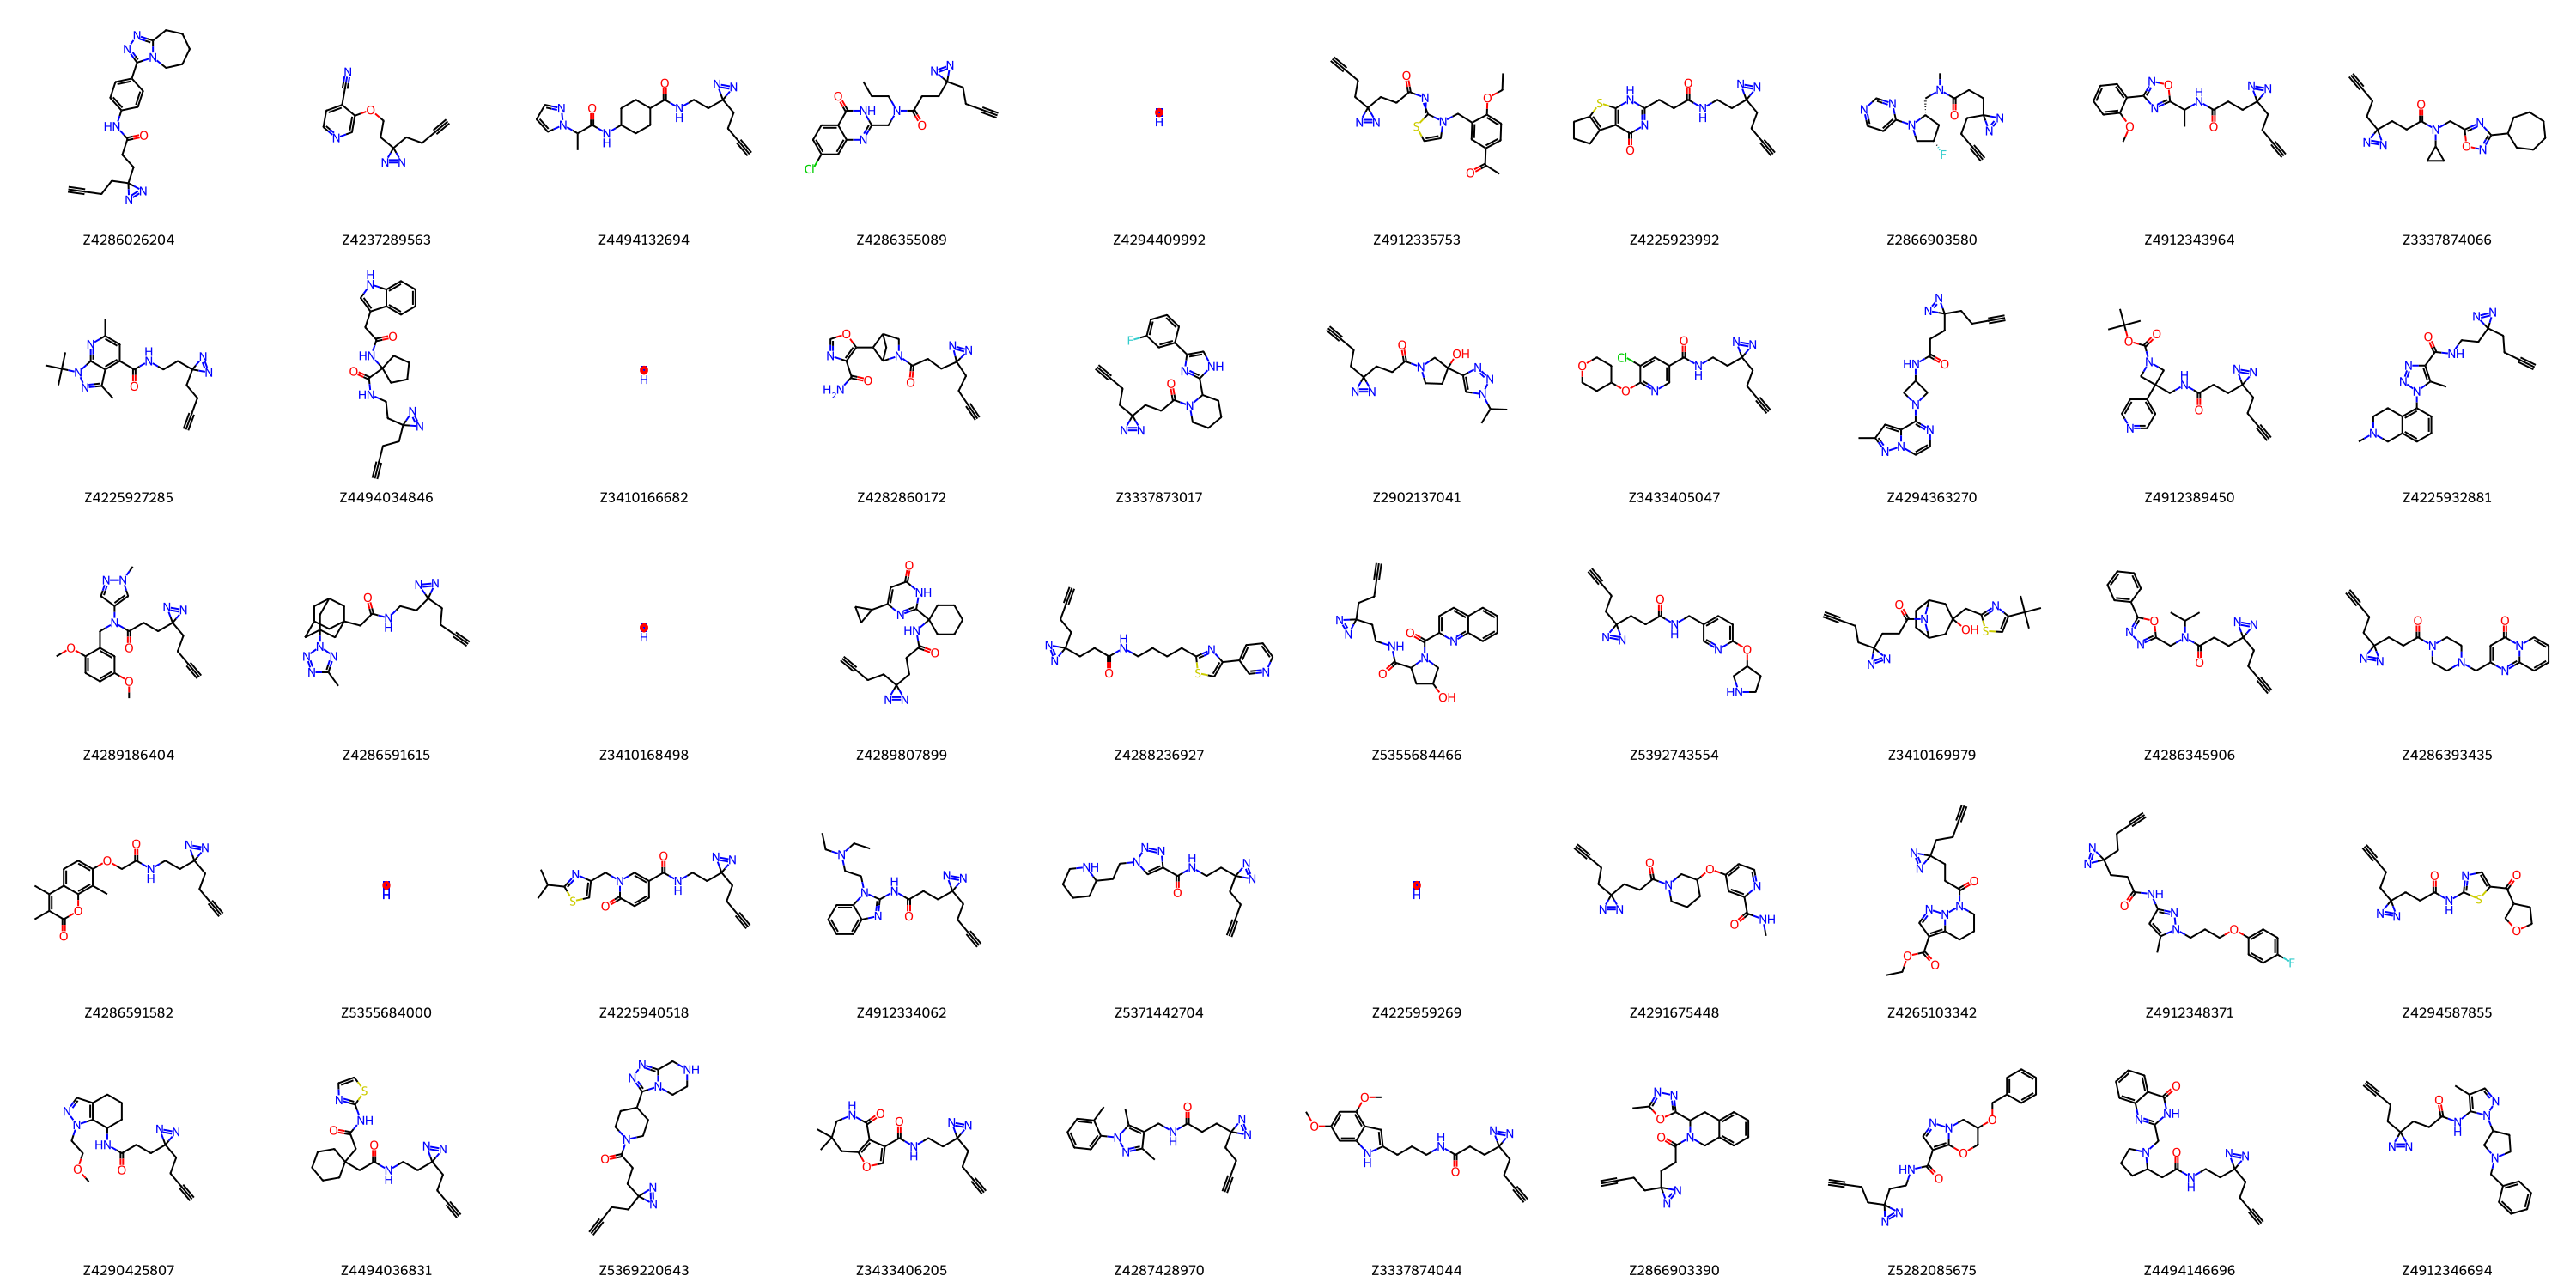

In [23]:
PandasTools.FrameToGridImage(filter_pick_df, column='ROMol', legendsCol='Catalog ID', molsPerRow=10, subImgSize=(300, 300))

## Save subset libary to an excel file

### Save parameters:

* **dataframe** (1st position): dataframe to save
* **outfile** (2nd position, str): name of excel file
* **molCol** (kwar, list(str)): name of columns containing molecules
* **size** (kwar, tuple(int)): size of molecule image in excel file

In [12]:
PandasTools.SaveXlsxFromFrame(filter_pick_df, 'filtered_library_100_1.xlsx', molCol=['ROMol','Fragment'], size=(150, 150))

## Save subset libary to an sdf file

### Save parameters:

* **dataframe** (1st position): dataframe to save
* **outfile** (2nd position, str): name of excel file
* **molCol** (kwar, list(str)): name of columns containing molecules
* **idname** (kwar, str): name of column used for molecule title
* **properties**: (kwar, list): column names of properties to inbed in the sdf file
* **allNumeric**: (kwar, bool): embed all numeric columns in sdf file
* **forceV3000**: (kwar, bool): force sdf to be encoded using V3000 (more feature-rich than V2000)

In [14]:
PandasTools.WriteSDF(filter_pick_df, 'filtered_library_100_1.sdf', molColName='ROMol', idName='Catalog ID', properties=list(df.columns), allNumeric=False, forceV3000=True)